### Settings & imports

Estas celdas realizan algunos pasos previos a la ejecución que son necesarios para la misma:
- Conectar Google Drive para leer y escribir ficheros que persistan tras la ejecución (modelos, pesos, datasets, resultados, etc.)
- Actualizar la librería music21, ya que a veces ha pasado que la versión instalada por defecto cuando se inicia el kernel es una anterior, que no es compatible con las últimas actualizaciones y se rompe al intentar parsear los ficheros MIDI
- Importar las librerías que se van a utilizar en el proyecto

In [4]:
ENV = 'local'
if(ENV == 'colab'):
  BASE_PATH = '/content/drive/MyDrive/uni/TFG2023/generative-music/'
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install --upgrade music21
    
elif(ENV == 'local'):
  BASE_PATH = './'
else:
  raise Exception()

In [ ]:
import music21 as m21
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K 
import tensorflow.keras as keras
import tensorflow as tf
import gc
import pickle

### Base generator class

La clase MusicGenerator engloba toda la funcionalidad necesaria para generar un caso de prueba.
Empieza por inicializar la prueba, definiendo los siguientes parámetros:
- **mode**: Determina si es una prueba nueva o si requiere cargar un modelo guardado en el parámetro __store_path__.
- **store_path**: Ruta donde guardar todos los ficheros resultantes de la ejecución.
- **seq_len**: longitud de la secuencia para generar el dataset de entrenamiento (por defecto 32)
- **delimiter**: carácter delimitador entre piezas musicales, _delimiter * seq_len_ determina el principio de una nueva pieza musical
- **input_type**: permite alternar entre los dos tipos de input_shape, single o multi (por defecto multi)

Al crear un objeto de la clase MusicGenerator, se inicializan las siguientes configuraciones en función del parámetro **mode**:
- **mode = 'build'**: Crea el árbol de ficheros para la prueba en el **store_path**, e inicializa todo a None.
- **mode = 'load'**: Carga las tablas de notas y duraciones, yel modelo almacenado en la ruta (si lo hubiera).

### Funciones
#### load_song_data()

La función **load_song_data(song_path)** parsea y carga en memoria todos los ficheros de formato MIDI (.mid) que encuentre en *song_path*. Para ello utiliza la librería Music21, que convierte todos los ficheros en objetos que contienen la información de compases, notas, acordes, duraciones y pistas de la canción almacenada en el fichero. Esta información se carga en dos listas del mismo tamaño que contienen la información de notas y duraciones para cada timestep:
- self.notes contiene la información de las notas y acordes de todas las canciones leídas, separando cada canción por medio de _delimiter*seq_len_ 
- self.durations contiene la información de la duración de la nota en el mismo índice para cada timestep.

Esta función también crea las llamadas lookup tables para notas y duraciones, que son dos diccionarios que asocian cada nota, acorde y duración encontrados en las canciones a un número entero que las codifica.

#### create_dataset()

La función **create_dataset()** genera una tupla (inputs, outputs) donde inputs es una lista [notes, durations] que contiene las notas y duraciones para cada *seq_len* timesteps, y outputs contiene la [note, duration] para el timestep *seq_len + 1*. Estas dos matrices están en la forma esperada por el modelo, de manera que sirvan para su entrenamiento.

#### build_model()

La función **build_model()** recibe a su vez una función mediante el parámetro _builder_. Esta función debe definir la estructura del modelo que se va a usar en la prueba, de manera que se puedan intercambiar diferentes modelos cambiando la función _builder_. Una vez ejecutada la función build_model(), el modelo está guardado en self.model, listo para ser entrenado.

#### fit_model()

La función **fit_model()** entrena el modelo con las inputs y outputs creadas anteriormente, durante las épocas definidas en *epochs*. Al finalizar el entrenamiento, guarda el modelo y los pesos en la ruta *./weights*.

####  generate()

La función **generate()** genera una nueva muestra de música, a partir de *seed* (que puede ser un fichero MIDI existente o un array  vacío), generando la cantidad de timesteps definidos en *num_steps*.


In [ ]:
DATASET_PATH = './data/nesmdb_midi'
SEQ_LEN = 32

NUM_UNITS = [256]
LOSS = 'categorical_crossentropy'
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 64

class MusicGenerator:
    
    def __init__(self, mode, store_path, seq_len=SEQ_LEN, delimiter='/', input_type='multi'): 
        
        self.store_path = os.path.join('runs',store_path)
        self.seq_len = seq_len
        self.delimiter = delimiter
        self.mode = mode
        self.input_type = input_type
        self.model_path = os.path.join(self.store_path, f'model_{self.input_type}-input.h5')
        self.saved_songs = 0
        self.model = None
        
        print(f'MODE SET TO: {self.mode}')
        
        if (self.mode=='build'):
            print('BUILD MODE')
            print("""A new directory will be created for this run,
                    where vocabularies and lookup tables will be stored upon creation.
                    Everything is set to 0.""")
            
            os.mkdir(self.store_path)
            os.mkdir(os.path.join(self.store_path,'weights'))
            self.note_lookup_table = None
            self.duration_lookup_table = None
            self.note_vocab_size = 0
            self.duration_vocab_size = 0
            self.song_data = {} 
            self.notes = None
            self.durations = None
            
        elif(self.mode=='load'):
            print('LOAD MODE')
            print("""An existing run will be loaded from the directory,
                    loading existing vocabularies, lookup tables and model.""")
            
            # load notes & durations from pickle
            with open(os.path.join(self.store_path, 'notes'),'rb') as fn:
                self.notes = pickle.load(fn)
            
            with open(os.path.join(self.store_path, 'durations'),'rb') as fd:
                self.durations = pickle.load(fd)
                
            # load lookup tables
            self.note_vocab_size,self.note_lookup_table = self.load_lookup_table(self.notes)
            self.duration_vocab_size,self.duration_lookup_table = self.load_lookup_table(self.durations)
                
            # load model
            if(os.path.exists(self.model_path)):
                print('Loaded model')
                self.model = keras.models.load_model(self.model_path)
                self.model.summary()
        else:
            raise Exception(f"Invalid value for mode: {mode}. Must be either 'build' or 'load'.")
            
        
    def load_song_data(self,song_path):
        
        if(self.mode == 'load'):
            raise Exception("Running mode set to 'load'")
            
        # Get song data from data_path and parse it as a Music21 object
        songs = {}

        for path,subdir,files in os.walk(song_path):
            for file in files:
                if (file[-3:] == 'mid'):
                    try:
                        song = m21.converter.parse(os.path.join(path,file)).chordify()
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
        print(f'Found {len(songs)} valid songs. Parsing song notes...')
        self.load_notes(songs)
        print('Finished loading songs.')
        
    def load_notes(self, song_data):
        # Load songs
        titles, songs = list(song_data.keys()), list(song_data.values())

        notes = []
        durations = []

        # Clean short songs
        for i,song in enumerate(songs):
            # Clean short songs
            if(song.duration.quarterLength < 1):
                print(f'Skipping song {titles[i]} with duration {song.duration.quarterLength}')
                continue
            
            if(i%10==0):
                print(f'Parsed {i} songs.')
            
            song_notes, song_durations = self.__encode_song(song)
            notes=notes + [self.delimiter] * self.seq_len
            notes=notes + song_notes
            durations=durations + [0] * self.seq_len
            durations=durations + song_durations
            

        print(f'Parsed {len(song_data)} songs.')
        
        print('Building lookup tables for notes...')
        self.note_vocab_size,self.note_lookup_table = self.load_lookup_table(notes)
        print(f'Note vocabulary size: {self.note_vocab_size}')
        
        print('Building lookup tables for durations...')
        self.duration_vocab_size,self.duration_lookup_table = self.load_lookup_table(durations)
        print(f'Duration vocabulary size: {self.duration_vocab_size}')
        
        self.notes = notes
        self.durations = durations
        
        with open(os.path.join(self.store_path, 'notes'),'wb') as fn:
            pickle.dump(notes,fn)
            
        with open(os.path.join(self.store_path, 'durations'),'wb') as fd:
            pickle.dump(durations,fd)
        
        del song_data
        
    def load_lookup_table(self,elements):
        return len(list(set(elements))),{v:i for i,v in enumerate(list(set(elements)))}
        
    def load_lookup_tables(self,notes,durations):
        self.note_lookup_table = {v:i for i,v in enumerate(list(set(notes)))}
        self.duration_lookup_table = {v:i for i,v in enumerate(list(set(durations)))}
        self.vocab_size = len(self.lookup_table.keys())
    
    def create_dataset(self):
        print(f'Creating network inputs and outputs from stored song data.')
        if(self.input_type == 'multi'):
            return self.create_dataset_multi_input()
        elif(self.input_type == 'single'):
            return self.create_dataset_single_input()
        else:
            raise Exception('Invalid version.')
            
    def create_dataset_multi_input(self):
        print('Creating multi-input dataset.')
    
        note_inputs = []
        duration_inputs = []
        note_outputs = []
        duration_outputs = []

        for i in range(len(self.notes)-self.seq_len):
            note_sequence_in = self.notes[i:i + self.seq_len]
            duration_sequence_in = self.durations[i:i + self.seq_len]
            note_sequence_out = self.notes[i + self.seq_len]
            duration_sequence_out = self.durations[i + self.seq_len]

            note_inputs.append([self.note_lookup_table[char] for char in note_sequence_in])
            duration_inputs.append([self.duration_lookup_table[char] for char in duration_sequence_in])
            note_outputs.append(self.note_lookup_table[note_sequence_out])
            duration_outputs.append(self.duration_lookup_table[duration_sequence_out])

        note_inputs = np.reshape(note_inputs, (len(note_inputs), self.seq_len))
        duration_inputs = np.reshape(duration_inputs, (len(duration_inputs), self.seq_len))
        inputs = [note_inputs,duration_inputs]
        
        note_outputs = to_categorical(note_outputs,self.note_vocab_size)
        duration_outputs = to_categorical(duration_outputs,self.duration_vocab_size)
        outputs = [note_outputs, duration_outputs]
        

        del self.notes
        del self.durations
        gc.collect()
        print(f'Input shape: {inputs[0].shape}')
        print(f'Output shape: {outputs[0].shape}')
        
        return (inputs, outputs)
    
    
    def create_dataset_single_input(self):
    
        print('Creating single-input dataset.')
        inputs = []
        note_outputs = []
        duration_outputs = []

        for i in range(len(self.notes)-self.seq_len):
            note_sequence_in = self.notes[i:i + self.seq_len]
            duration_sequence_in = self.durations[i:i + self.seq_len]
            
            note_sequence_out = self.notes[i + self.seq_len]
            duration_sequence_out = self.durations[i + self.seq_len]

            note_sequence_in=[self.note_lookup_table[char] for char in note_sequence_in]
            duration_sequence_in=[self.duration_lookup_table[char] for char in duration_sequence_in]
            
            note_sequence_out=self.note_lookup_table[note_sequence_out]
            duration_sequence_out=self.duration_lookup_table[duration_sequence_out]
            
            sequence_in = [list(a) for a in zip(note_sequence_in,duration_sequence_in)]
            
            note_outputs.append(note_sequence_out)
            duration_outputs.append(duration_sequence_out)
            
            inputs.append(sequence_in)

        inputs = np.reshape(inputs, (len(inputs), self.seq_len, 2))
        
        note_outputs = to_categorical(note_outputs,self.note_vocab_size)
        duration_outputs = to_categorical(duration_outputs,self.duration_vocab_size)
        outputs = [note_outputs, duration_outputs]
        

        del self.notes
        del self.durations
        gc.collect()
        
        print(f'Input shape: {inputs[0].shape}')
        print(f'Output shape: {outputs[0].shape}')
        
        return (inputs, outputs)
    
    def build_model(self, builder, num_units, loss, lr, embed_size = 100, coerce=False):
        if(self.model is not None and not coerce):
            raise Exception('A model already exists!')
            
        model_params = {
            'seq_len': self.seq_len,
            'note_vocab_size':self.note_vocab_size,
            'duration_vocab_size':self.duration_vocab_size
        }
            
        model, att_model = builder(model_params, num_units, loss, lr, embed_size)
            
        model.summary()
        self.model = model
        self.model.save(self.model_path) 
    
    def fit_model(self,inputs, outputs, epochs=EPOCHS, batch_size=BATCH_SIZE):
        weights_folder = os.path.join(self.store_path, 'weights')
        
        checkpoint1 = ModelCheckpoint(
            os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        checkpoint2 = ModelCheckpoint(
            os.path.join(weights_folder, "weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [
            checkpoint1
            , checkpoint2
            , early_stopping
         ]

        self.model.save_weights(os.path.join(weights_folder, "weights.h5"))
        self.model.fit(inputs, outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , shuffle=True
                 )
        
        self.model.save(self.model_path)
        
    def generate(self, seed, num_steps, max_seq_len, temperature):
        
        note_stream, duration_stream = seed
        
        # create seed with start symbol
        notes_seed, durations_seed = seed
        
        notes_seed = [self.delimiter] * self.seq_len + notes_seed
        notes_seed = [self.note_lookup_table[symbol] for symbol in notes_seed]

        durations_seed = [0] * self.seq_len + durations_seed
        durations_seed = [self.duration_lookup_table[symbol] for symbol in durations_seed]
        
        
        for _ in range(num_steps):
            
            # limit seed to max_seq_len
            notes_seed = notes_seed[-self.seq_len:]
            durations_seed = durations_seed[-self.seq_len:]
            
            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            # network_input = [np.reshape(notes_seed,(1,64)),np.reshape(durations_seed,(1,self.seq_len))]
            if(self.input_type == 'multi'):
                network_input = [np.reshape(notes_seed,(1,self.seq_len)),np.reshape(durations_seed,(1,self.seq_len))]
            elif(self.input_type == 'single'):
                network_input = [list(a) for a in zip(notes_seed,durations_seed)]
                network_input = np.reshape(network_input,(1,self.seq_len,2))
            else:
                raise Exception('Invalid version.')
            
            
            # make a prediction
            note_prob_dist, duration_prob_dist = self.model.predict(network_input)
            # [0.1, 0.2, 0.1, 0.6] example -> softmax adds to 1
            
            note_output = self._sample_with_temperature(note_prob_dist[0], temperature)
            duration_output = self._sample_with_temperature(duration_prob_dist[0], temperature)
            
            # update seed
            notes_seed.append(note_output)
            durations_seed.append(duration_output)
            
            # map int to encoding
            note_symbol = [k for k, v in self.note_lookup_table.items() if v == note_output][0]
            duration_symbol = [k for k, v in self.duration_lookup_table.items() if v == duration_output][0]
            
            # check end of melody
            if (note_symbol == '/'):
                break
            
            # update melody
            note_stream.append(note_symbol)
            duration_stream.append(duration_symbol)
            
        return [note_stream, duration_stream]
    
    
    def save(self, song, step_duration=0.25, format='midi'):
        
        filename = self.store_path + '/gensong_' +str(self.saved_songs) + '_' + str(self.input_type) + '-input.midi'
        self.saved_songs+=1
         
        # create a music21 stream
        stream = m21.stream.Stream()
        
        # pass symbols in melody and create note/rest/chord objects
        start_symbol = None
        step_counter = 1
        
        notes, durations = song
        
        for i in range(len(notes)):
            
            current_note = notes[i]
            current_duration = durations[i]
            
            if(current_note == 'r'):
                # rest
                m21_event = m21.note.Rest(quarterLength=current_duration)

            elif('.' in current_note):
                # chord
                pitches = [int(p) for p in current_note.split('.')]
                m21_event = m21.chord.Chord(pitches,quarterLength=current_duration)

            else:
                # note
                m21_event = m21.note.Note(int(current_note), quarterLength=current_duration)

            stream.append(m21_event)
                
        
        # write music21 stream to midi file
        stream.write(format,filename)
        
        
    def get_seed_from_midi(self,midi_path):
        song = m21.converter.parse(midi_path).chordify()
        encoded = self.__encode_song(song)
        return encoded
        
    
    def __encode_song(self, song, time_step=0.25):
        encoded_notes = []
        encoded_durations = []
        for event in song.flat.notesAndRests:
            if(isinstance(event,m21.note.Note)):
                symbol = str(event.pitch.midi)
                duration = event.duration.quarterLength
            elif(isinstance(event,m21.note.Rest)):
                symbol = 'r'
                duration = event.duration.quarterLength
            elif(isinstance(event,m21.chord.Chord)):
                symbol = '.'.join([str(p.midi) for p in event.pitches]) 
                duration = event.duration.quarterLength
            elif(isinstance(event,m21.note.Unpitched) or isinstance(event,m21.percussion.PercussionChord) ):
                continue
            else:
                raise Exception(f'unknown event type {type(event)}')

            encoded_notes.append(symbol)
            encoded_durations.append(duration)
        return encoded_notes, encoded_durations
        
    def __convert_song(self,song):
        return [self.lookup_table[symbol] for symbol in song] 
    
    def _sample_with_temperature(self, probabilities, temperature):
        # temperature -> inf then acts like random sampling
        # temperature -> 0 then the highest prob wins
        # temperature -> 1 
        # how explorative we want the network to be

        predictions = np.log(probabilities) / temperature
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(probabilities)) # [0, 1, 2 ,3]
        index = np.random.choice(choices, p=probabilities) # sample from probability distribution
            
        return index
        
        

### Builder functions

En este apartado se definen las distintas funciones que se le pueden pasar como _builder function_ a la función *build_model()*, que sirven para generar el modelo generativo correspondiente.

Hasta el momento, existen las siguientes:

#### build_lstm_multi_input()

Construye un modelo basado en una red neuronal LSTM con mecanismo de atención, y con dos Embedding layers que aprenden la representación vectorial de las entradas [notes,  durations]

#### build_lstm_single_input()

Construye el mismo modelo que la función anterior, pero esperando una entrada del tipo [[note_1, duration_1], [note_2, duration_2], ...,  [note_n, duration_n]], de manera que se prescinde de las Embedding layers.

In [ ]:
# BUILDER FUNCTIONS
def build_lstm_multi_input(build_params, num_units, loss, lr, embed_size = 100, with_attention=True):

    # create model architecture
    note_input = keras.layers.Input(shape=(build_params['seq_len'],))
    duration_input = keras.layers.Input(shape=(build_params['seq_len']))

    x1 = keras.layers.Embedding(build_params['note_vocab_size'], embed_size)(note_input)
    x2 = keras.layers.Embedding(build_params['duration_vocab_size'], embed_size)(duration_input) 

    x = keras.layers.Concatenate()([x1,x2])

    x = keras.layers.LSTM(num_units[0],return_sequences=True)(x)
    #x = keras.layers.Dropout(0.2)(x)

    c = keras.layers.LSTM(num_units[0], return_sequences=True)(x)
    #x = keras.layers.Dropout(0.2)(x)

    if(with_attention):
      # ATTENTION MECHANISM
      e = keras.layers.Dense(1, activation='tanh')(c)
      e = keras.layers.Reshape([-1])(e)
      alpha = keras.layers.Activation('softmax')(e)

      alpha_repeated = keras.layers.Permute([2,1])(keras.layers.RepeatVector(num_units[0])(alpha))

      c = keras.layers.Multiply()([x, alpha_repeated])
      c = keras.layers.Lambda(lambda xi: K.sum(xi,axis=1), output_shape=(num_units[0],))(c)

      note_output = keras.layers.Dense(build_params['note_vocab_size'], activation='softmax')(c)
      duration_output = keras.layers.Dense(build_params['duration_vocab_size'], activation='softmax')(c)

      model = keras.Model([note_input, duration_input], [note_output,duration_output],name='embedding_lstm')
      att_model = keras.Model([note_input, duration_input], alpha, name='embedding_attention_model')
    else:
      note_output = keras.layers.Dense(build_params['note_vocab_size'], activation='softmax')(c)
      duration_output = keras.layers.Dense(build_params['duration_vocab_size'], activation='softmax')(c)

      model = keras.Model([note_input, duration_input], [note_output,duration_output],name='embedding_lstm')
      att_model = None

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=lr) # keras.optimizers.RMSprop(lr = lr)
    model.compile(loss=[loss,loss], optimizer=optimizer, metrics=['accuracy'])
    return model, att_model




def build_lstm_single_input(build_params, num_units, loss, lr, embed_size = 100, with_attention=True):

    # create model architecture

    i = keras.layers.Input(shape=(build_params['seq_len'],2))

    x = keras.layers.LSTM(num_units[0],return_sequences=True)(i)
    #x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.LSTM(num_units[0])(x)
    c = keras.layers.Dropout(0.2)(x)

    if(with_attention):
      # ATTENTION MECHANISM
      e = keras.layers.Dense(1, activation='tanh')(x)
      e = keras.layers.Reshape([-1])(e)
      alpha = keras.layers.Activation('softmax')(e)

      alpha_repeated = keras.layers.Permute([2,1])(keras.layers.RepeatVector(num_units[0])(alpha))

      c = keras.layers.Multiply()([x, alpha_repeated])
      c = keras.layers.Lambda(lambda xi: K.sum(xi,axis=1), output_shape=(num_units[0],))(c)

      note_output = keras.layers.Dense(build_params['note_vocab_size'], activation='softmax')(c)
      duration_output = keras.layers.Dense(build_params['duration_vocab_size'], activation='softmax')(c)

      model = keras.Model(i, [note_output,duration_output], name='single_input_lstm')
      att_model = keras.Model(i, alpha, name='single_input_attention_model')
    else:
      note_output = keras.layers.Dense(build_params['note_vocab_size'], activation='softmax')(c)
      duration_output = keras.layers.Dense(build_params['duration_vocab_size'], activation='softmax')(c)

      model = keras.Model(i, [note_output,duration_output], name='single_input_lstm')
      att_model = None
    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=lr) # keras.optimizers.RMSprop(lr = lr)
    model.compile(loss=[loss,loss], optimizer=optimizer, metrics=['accuracy'])

    return model, att_model

### New run

In [ ]:
mg = MusicGenerator('build', '/content/drive/MyDrive/uni/TFG2023/generative_music/rnn',input_type='multi',seq_len=SEQ_LEN)

MODE SET TO: build
BUILD MODE
A new directory will be created for this run,
                    where vocabularies and lookup tables will be stored upon creation.
                    Everything is set to 0.


In [ ]:
mg.load_song_data('/content/drive/MyDrive/uni/TFG2023/generative_music/data/chopin/full')

/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQ

Parsing file chpn_op33_2.mid failed. Skipping.


/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Parsing file chpn_op35_2.mid failed. Skipping.


/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2002 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2002 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Found 46 valid songs. Parsing song notes...
Parsed 0 songs.
Parsed 10 songs.
Parsed 20 songs.
Parsed 30 songs.
Parsed 40 songs.
Parsed 46 songs.
Building lookup tables for notes...
Note vocabulary size: 10978
Building lookup tables for durations...
Duration vocabulary size: 31
Finished loading songs.


### Create dataset

In [ ]:
inputs, outputs = mg.create_dataset()

Creating network inputs and outputs from stored song data.
Creating multi-input dataset.
Input shape: (44280, 32)
Output shape: (44280, 10978)


### Build model

In [ ]:
model = mg.build_model(build_lstm_multi_input,NUM_UNITS,LOSS,LR,coerce=True)

Model: "embedding_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 100)      1097800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 100)      3100        ['input_2[0][0]']                
                                                                                     

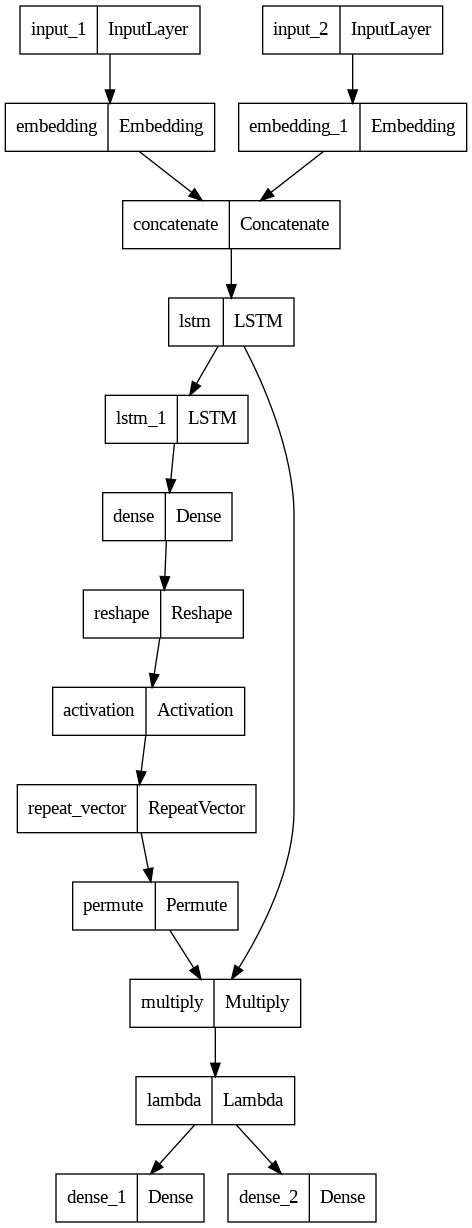

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(mg.model)

In [ ]:
# model[0].load_weights('runs/bach616/model_v1.h5')

### Fit model

In [ ]:
mg.fit_model(inputs,outputs,epochs=100,batch_size=BATCH_SIZE)

Epoch 1/100
692/692 [==============================] - 78s 98ms/step - loss: 8.9094 - dense_4_loss: 7.9329 - dense_5_loss: 0.9766 - dense_4_accuracy: 0.0692 - dense_5_accuracy: 0.6780
Epoch 2/100
692/692 [==============================] - 22s 32ms/step - loss: 7.2986 - dense_4_loss: 6.5472 - dense_5_loss: 0.7514 - dense_4_accuracy: 0.0901 - dense_5_accuracy: 0.7215
Epoch 3/100
692/692 [==============================] - 17s 25ms/step - loss: 6.2596 - dense_4_loss: 5.5724 - dense_5_loss: 0.6872 - dense_4_accuracy: 0.1127 - dense_5_accuracy: 0.7395
Epoch 4/100
692/692 [==============================] - 15s 22ms/step - loss: 5.4170 - dense_4_loss: 4.7856 - dense_5_loss: 0.6314 - dense_4_accuracy: 0.1382 - dense_5_accuracy: 0.7600
Epoch 5/100
692/692 [==============================] - 16s 23ms/step - loss: 4.7363 - dense_4_loss: 4.1561 - dense_5_loss: 0.5802 - dense_4_accuracy: 0.1667 - dense_5_accuracy: 0.7801
Epoch 6/100
692/692 [==============================] - 14s 20ms/step - loss: 4.2

In [ ]:
mg.model.summary()

Model: "embedding_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 100)      1097800     ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 100)      3100        ['input_3[0][0]']                
                                                                                     

### Load run (loads model)

In [ ]:
 print(tf. __version__)

2.10.0


In [ ]:
model = keras.models.load_model('runs/bach616/model_v0.h5')

In [ ]:
mg = MusicGeneratorWithAttention('load', 'bach997',version=0)

load run
Loaded model
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 100)      47100       ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 32, 100)      2200        ['input_6[0][0]']                
                                                                      

In [ ]:
gc.collect()

4159

### Generate new music

In [ ]:
# seed =  mg.get_seed_from_midi('./runs/bach001/bach_seed.mid')
song = mg.generate(([],[]),100,32,0.1)

1/1 [==============================] - 0s 22ms/step


In [ ]:
mg.save(song)

In [ ]:
def load_song_data(self,song_path):
        
        if(self.mode == 'load'):
            raise Exception("Running mode set to 'load'")
            
        # Get song data from data_path and parse it as a Music21 object
        songs = {}

        for path,subdir,files in os.walk(song_path):
            for file in files:
                if (file[-3:] == 'mid'):
                    song = m21.converter.parse(os.path.join(path,file)).chordify()
                    songs[file[:-4]] = song
        print(f'Found {len(songs)} valid songs. Parsing song notes...')
        self.load_notes(songs)
        print('Finished loading songs.')

In [ ]:
for path,subdir,files in os.walk('/content/drive/MyDrive/generative_music/data/chopin/full'):
            for file in files:
                if (file[-3:] == 'mid'):
                  print(file)
                  song = m21.converter.parse(os.path.join(path,file)).chordify()

chpn_op10_e05.mid
chpn_op10_e12.mid
chpn_op10_e01.mid
chpn_op7_1.mid
chpn_op7_2.mid
chp_op18.mid
chpn_op23.mid
chpn_op25_e2.mid
chpn_op25_e3.mid
chpn_op25_e4.mid
chpn_op25_e11.mid
chpn_op25_e12.mid
chpn_op27_1.mid
chpn_op27_2.mid
chpn-p1.mid
chpn-p2.mid
chpn-p3.mid
chpn-p4.mid
chpn-p5.mid
chpn-p6.mid
chpn-p7.mid
chpn-p8.mid
chpn-p10.mid
chpn-p11.mid
chpn-p12.mid
chpn-p13.mid
chpn-p14.mid
chpn-p15.mid
chpn-p16.mid
chpn-p17.mid
chpn-p18.mid
chpn-p19.mid
chpn-p20.mid
chpn-p21.mid
chpn-p22.mid
chpn-p23.mid
chpn-p24.mid
chp_op31.mid
chpn_op33_2.mid


KeyError: ignored